In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

1. Исходные данные

In [2]:
# Значения предикторов для прогноза целевой переменной
A_max = (1800, 1500, 1800, 2000, 1500)

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.01
k_b = 0.05

# Отн. размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_acc = pd.read_excel('C:\Datasets/dataset_z_acc.xlsx')

In [4]:
df = pd.read_excel('C:\Datasets/dataset_0.xlsx')
df.round(2)

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,400.55,198.31,450.98,604.77,200.18,49.74
1,401.92,199.81,451.80,603.09,201.09,49.71
2,402.32,201.75,449.05,604.77,199.56,54.21
3,400.59,200.83,450.81,603.49,201.93,51.76
4,399.40,200.61,454.86,600.54,200.22,53.06
...,...,...,...,...,...,...
995,834.91,419.82,954.10,1257.51,424.43,110.52
996,843.21,415.82,964.41,1259.49,427.98,114.27
997,841.24,419.41,968.42,1268.53,429.17,109.03
998,842.05,416.33,962.46,1247.15,428.48,105.98


3. Попарные графики рассеяния

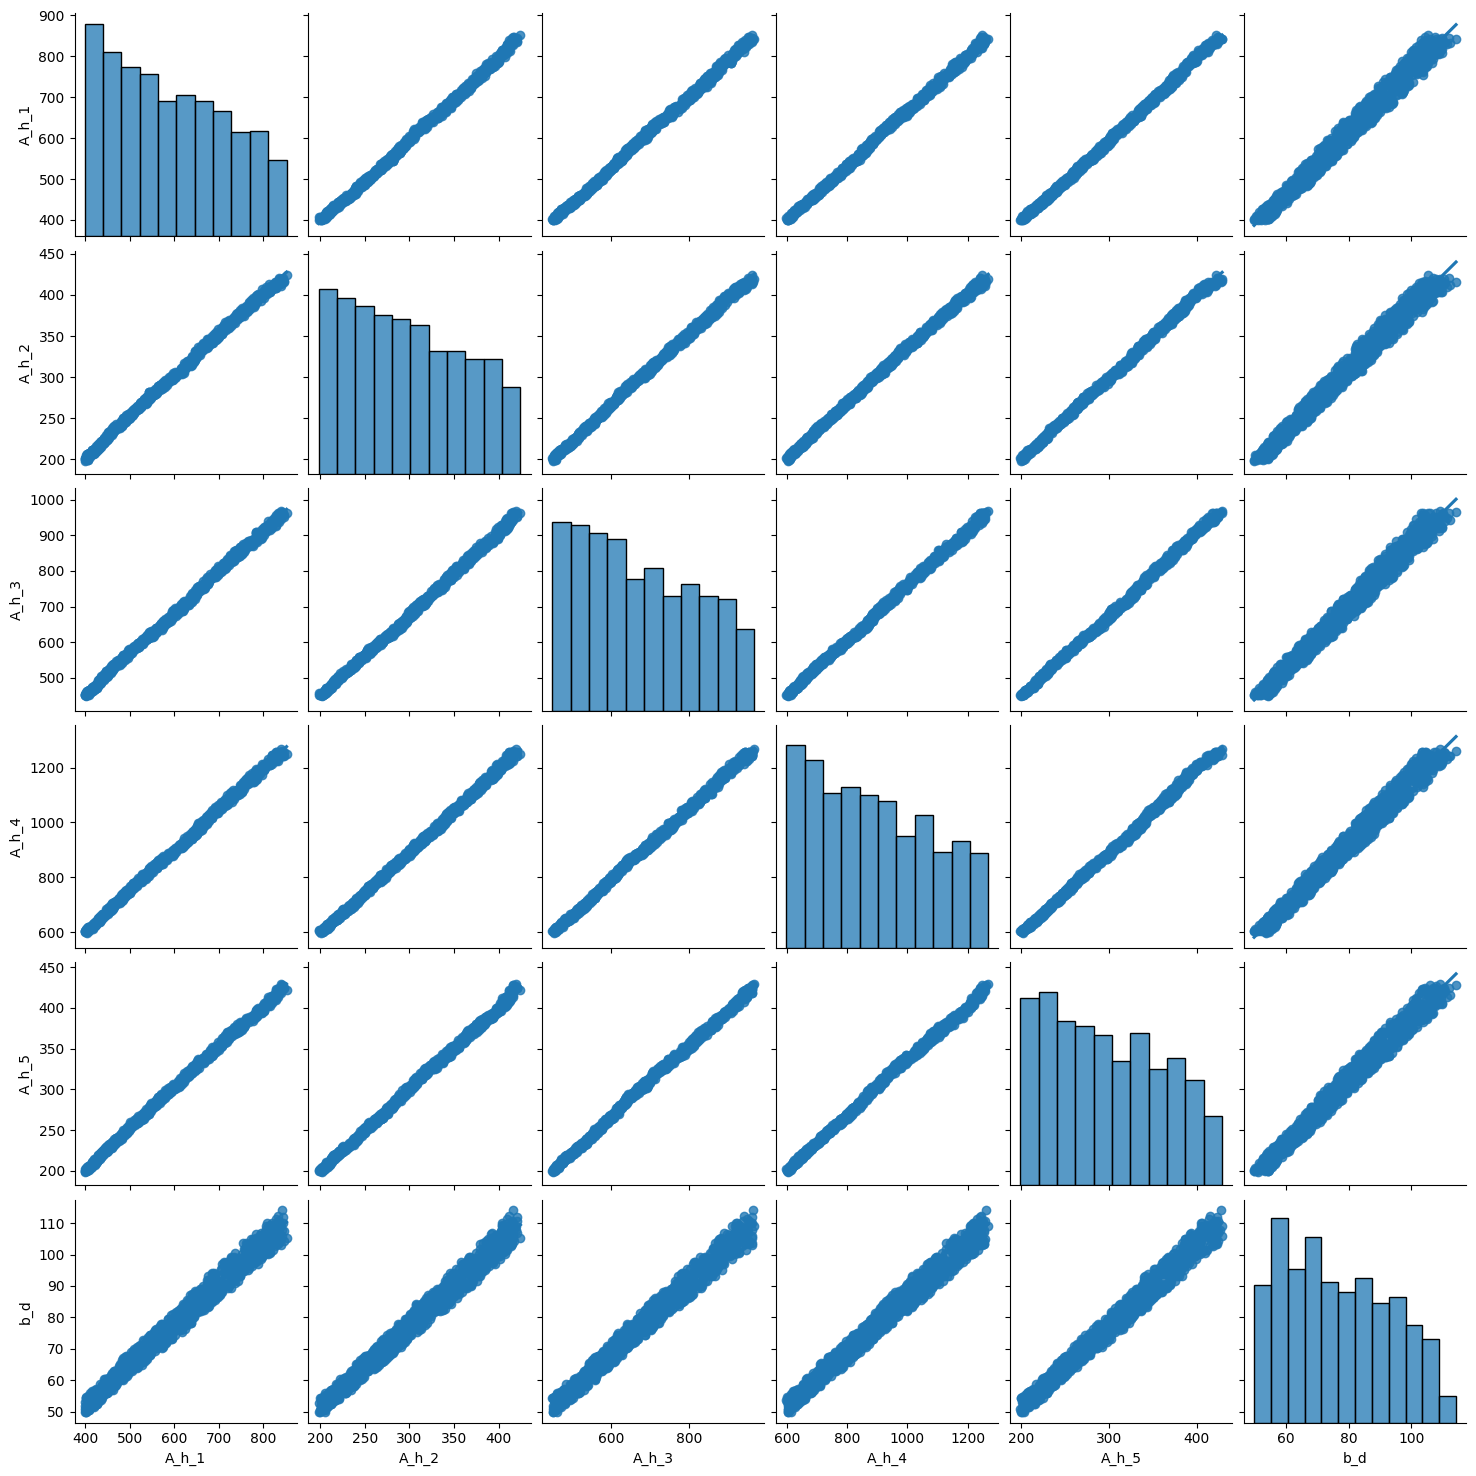

In [5]:
sns.pairplot(df, kind="reg")
plt.show()

4. Выделение X и y из df

In [6]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values                                         

5. Масштабирование признаков и вектора A_max

In [7]:
sc = MaxAbsScaler() # MaxAbsScaler()    MinMaxScaler()    RobustScaler()    StandardScaler()
X_std = sc.fit_transform(X)

In [8]:
A_max_std = sc.transform([A_max])
A_max_std.round(3)

array([[2.111, 3.536, 1.859, 1.577, 3.495]])

6. Обучение моделей регрессоров

In [9]:
metrics = {}

In [10]:
lr = LinearRegression()
model_lr = lr.fit(X_std, y)

y_pred = model_lr.predict(X_std)
rmse_lr = np.sqrt(mean_squared_error(y, y_pred)).round(3)
mae_lr = mean_absolute_error(y, y_pred).round(3)
r2_lr = r2_score(y, y_pred).round(3)
b_max_lr = model_lr.predict(A_max_std)[0].round(3)
metrics['LinRegr'] = (r2_lr, b_max_lr)

print(f'RMSE train: {rmse_lr}')
print()
print(f'MAE train:  {mae_lr}')
print()
print(f'R2 train:   {r2_lr}')
print()
print(f'b max: {b_max_lr}')
print()
print('Коэффициенты регрессии:')
print(pd.DataFrame(model_lr.coef_[:], columns=['k']).round(3))
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')

RMSE train: 2.312

MAE train:  1.945

R2 train:   0.981

b max: 316.934

Коэффициенты регрессии:
        k
0  59.640
1  50.083
2  24.623
3 -28.009
4   3.476
Свободный член регрессии  a0 =  0.198


In [11]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-5, 5, num=51), 
                 'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_std, y)

y_rid_pred = model_rid.predict(X_std)
rmse_rid = np.sqrt(mean_squared_error(y, y_rid_pred)).round(3)
mae_rid = mean_absolute_error(y, y_rid_pred).round(3)
r2_rid = r2_score(y, y_rid_pred).round(3)
b_max_rid = model_rid.predict(A_max_std)[0].round(3)
metrics['Ridge'] = (r2_rid, b_max_rid)

print(f'RMSE train: {rmse_rid}')
print()
print(f'MAE train:  {mae_rid}')
print()
print(f'R2 train:   {r2_rid}')
print()
print(f'b max: {b_max_rid}')
model_rid.best_params_

RMSE train: 2.314

MAE train:  1.949

R2 train:   0.981

b max: 303.941


{'alpha': 0.01, 'random_state': 1}

In [12]:
las = Lasso()
las_parameters = {'alpha': np.logspace(-5, 5, num=51), 
                 'random_state':[1, 7, 42, 100]
}
model_las = GridSearchCV(estimator=las,
                   param_grid=las_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_las.fit(X_std, y)

y_las_pred = model_las.predict(X_std)
rmse_las = np.sqrt(mean_squared_error(y, y_las_pred)).round(3)
mae_las = mean_absolute_error(y, y_las_pred).round(3)
r2_las = r2_score(y, y_las_pred).round(3)
b_max_las = model_las.predict(A_max_std)[0].round(3)
metrics['Lasso'] = (r2_las, b_max_las)

print(f'RMSE train: {rmse_las}')
print()
print(f'MAE train:  {mae_las}')
print()
print(f'R2 train:   {r2_las}')
print()
print(f'b max: {b_max_las}')
model_las.best_params_

RMSE train: 2.317

MAE train:  1.952

R2 train:   0.98

b max: 291.151


{'alpha': 0.000630957344480193, 'random_state': 1}

In [13]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 5, num=51),
                    'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                    'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_std, y)

y_en_pred = model_en.predict(X_std)
rmse_en = np.sqrt(mean_squared_error(y, y_en_pred)).round(3)
mae_en = mean_absolute_error(y, y_en_pred).round(3)
r2_en = r2_score(y, y_en_pred).round(3)
b_max_en_hd = model_en.predict(A_max_std)[0].round(3)
metrics['ElastNet'] = (r2_en, b_max_en_hd)

print(f'RMSE train: {rmse_en}')
print()
print(f'MAE train:  {mae_en}')
print()
print(f'R2 train:   {r2_en}')
print()
print(f'b max: {b_max_en_hd}')
model_en.best_params_

RMSE train: 2.313

MAE train:  1.947

R2 train:   0.981

b max: 307.12


{'alpha': 1.584893192461114e-05, 'l1_ratio': 0.05, 'random_state': 1}

In [14]:
tsr = TheilSenRegressor()
tsr_parameters = {
    'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_std, y)

y_tsr_pred = model_tsr.predict(X_std)
rmse_tsr = np.sqrt(mean_squared_error(y, y_tsr_pred)).round(3)
mae_tsr = mean_absolute_error(y, y_tsr_pred).round(3)
r2_tsr = r2_score(y, y_tsr_pred).round(3)
b_max_tsr = model_tsr.predict(A_max_std)[0].round(3)
metrics['TheilSen'] = (r2_tsr, b_max_tsr)

print(f'RMSE train: {rmse_tsr}')
print()
print(f'MAE train:  {mae_tsr}')
print()
print(f'R2 train:   {r2_tsr}')
print()
print(f'b max: {b_max_tsr}')
model_tsr.best_params_

RMSE train: 2.314

MAE train:  1.948

R2 train:   0.981

b max: 323.745


{'random_state': 42}

7. Средние значения метрик регрессоров и целевой переменной b

In [15]:
r2_values = [metrics[key][-2] for key in metrics]
r2_mean = sum(r2_values) / len(r2_values)
b_max_values = [metrics[key][-1] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
metrics['Mean'] = (r2_mean.round(3), b_max_mean.round(3))

print(f'b_mean: {b_max_mean.round(3)}')

b_mean: 308.578


8. Обучение Feed Forward Neural Network

In [16]:
# Определение функции коэффициента детерминации R2
def r_squared(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (SS_res / SS_tot)


# Задание диапазона значений для числа слоев и числа нейронов
num_neurons_range = range(8, 25, 4)

# Задание диапазона значений для seed_value
seed_values = range(1900, 1911)

# Инициализация переменных для сохранения лучшей модели
best_r2 = -np.inf
sum_r2 = -np.inf

# Цикл обучения моделей с разным числом нейронов на каждом слое
for num_neurons_1 in num_neurons_range:
    for num_neurons_2 in num_neurons_range:
        print(f'Number of neurons in Layer 1: {num_neurons_1}, Number of neurons in Layer 2: {num_neurons_2}')
        
        for seed_value in seed_values:
            
            # Установка seed_value для генератора случайных чисел
            random.seed(seed_value)
            np.random.seed(seed_value)
            tf.random.set_seed(seed_value)

            model = Sequential()
            model.add(Dense(num_neurons_1, activation='relu', input_shape=(X_std.shape[1],)))
            model.add(Dense(num_neurons_2, activation='relu'))
            model.add(Dense(1, activation='linear'))

            model.compile(optimizer='adam', loss='mean_squared_error')
            early_stop = EarlyStopping(monitor='val_loss', patience=10)
            history = model.fit(X_std, y, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=0)

            y_pred = model.predict(X_std)
            r2 = r_squared(np.ravel(y), np.ravel(y_pred))
  
            print(f'r2 = {r2.round(7)}')
            print()

            if r2 > best_r2:
                best_r2 = r2
                best_num_neurons_1 = num_neurons_1
                best_num_neurons_2 = num_neurons_2
                best_seed = seed_value
                best_model = model
                best_history = history

Number of neurons in Layer 1: 8, Number of neurons in Layer 2: 8
32/32 [==============================] - 0s 1ms/step
r2 = 0.9622028

32/32 [==============================] - 0s 1ms/step
r2 = -18.7098333

32/32 [==============================] - 0s 1ms/step
r2 = 0.9640963

32/32 [==============================] - 0s 2ms/step
r2 = 0.9635285

32/32 [==============================] - 0s 1ms/step
r2 = 0.9412423

32/32 [==============================] - 0s 1ms/step
r2 = -18.7098552

32/32 [==============================] - 0s 1ms/step
r2 = 0.9471061

32/32 [==============================] - 0s 2ms/step
r2 = 0.9593537

32/32 [==============================] - 0s 1ms/step
r2 = 0.9517927

32/32 [==============================] - 0s 1ms/step
r2 = 0.9441243

32/32 [==============================] - 0s 1ms/step
r2 = 0.9622722

Number of neurons in Layer 1: 8, Number of neurons in Layer 2: 12
32/32 [==============================] - 0s 2ms/step
r2 = 0.9787455

32/32 [==============================

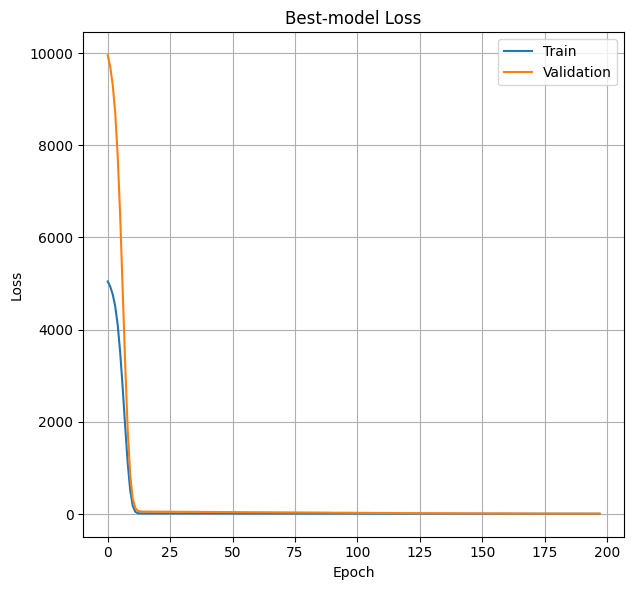

In [17]:
# Построение графиков функции потерь
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Best-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.tight_layout()  # Для более компактного расположения
plt.show()

In [18]:
print('R2_best:',    best_r2.round(5))
print('Число нейронов на слое 1 для лучшей модели:',  best_num_neurons_1)
print('Число нейронов на слое 2 для лучшей модели:',  best_num_neurons_2)
print('Значение seed для best-модели:',    best_seed)

R2_best: 0.97997
Число нейронов на слое 1 для лучшей модели: 24
Число нейронов на слое 2 для лучшей модели: 24
Значение seed для best-модели: 1907


In [22]:
y_NN_pred = best_model.predict(X_std)

rmse_NN = np.sqrt(mean_squared_error(y, y_NN_pred)).round(3)
mae_NN = mean_absolute_error(y, y_NN_pred).round(3)
r2_NN = r2_score(y, y_NN_pred).round(3)

b_max_NN = best_model.predict(A_max_std)[:].flatten()
metrics['NeuralNet_best'] = (str(r2_NN), np.round(b_max_NN, 1))

 1/32 [..............................] - ETA: 1s

1/1 [==============================] - 0s 190ms/step


In [23]:
print(f'Метрики для best-модели:')
print(f'RMSE train: {rmse_NN}')
print()
print(f'MAE train:  {mae_NN}')
print()
print(f'R2 train:   {r2_score(y, y_NN_pred).round(6)}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_best:    {np.round(b_max_NN, 1)}')

Метрики для best-модели:
RMSE train: 2.348

MAE train:  1.973

R2 train:   0.979972

Прогноз целевой переменной:
b max_best:    [283.8]


9. Определение коэффициента регуляризации alpha

In [24]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual

X_h = X_std
y_d = y
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

# Поиск коэффициента регуляризации alpha
calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
alpha = newton(calculate_delta_residual_partial, x0=1e-7, tol=1e-7)
# alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
# alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-5)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

Коэффициент регуляризации alpha = 1.38e+02


10. Регуляризированное решение системы уравнений

In [25]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_std @ z_hd
rmse_reg = np.sqrt(mean_squared_error(y_d, y_reg_hd_pred)).round(3)
mae_reg = mean_absolute_error(y_d, y_reg_hd_pred).round(3)
r2_reg = r2_score(y_d, y_reg_hd_pred).round(3)
b_max_reg = np.sum(A_max_std * z_hd).round(3)
metrics['Regularized'] = (r2_reg, b_max_reg)

print(f'RMSE train: {rmse_reg}')
print()
print(f'MAE train:  {mae_reg}')
print()
print(f'R2 train:   {r2_reg}')
print()
print(f'b_max_reg_hd: {b_max_reg}')

RMSE train: 4.668

MAE train:  3.96

R2 train:   0.921

b_max_reg_hd: 262.533


In [ ]:
N_feat = X_h.shape[1]

print("Точные масштабированные коэффициенты регрессии:")
for i in range(0, N_feat): 
    print((np.array(z_acc)[i] * np.amax(X[:, i])).round(2))
print()
print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
print("Регуляризованные масштабированные коэффициенты регрессии:")
for i in range(0, N_feat): 
    print(z_hd[i].round(2))

Точные масштабированные коэффициенты регрессии:
[34.11]
[14.85]
[29.05]
[25.37]
[6.87]

Коэффициент регуляризации alpha = 1.382e+02
Регуляризованные масштабированные коэффициенты регрессии:
20.77
21.01
20.82
20.92
20.8


11. Точный прогноз целевой переменной b

In [ ]:
b_max_acc = np.sum(A_max * np.array(z_acc).reshape(-1))
metrics['Accurate'] = ('', b_max_acc)

print(f'Accurate b_max: {b_max_acc}')

Accurate b_max: 242.5


12. Сводная таблица метрик моделей

In [26]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2', 'b_max']

print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
df_metrics

Коэффициент регуляризации alpha = 1.382e+02


,LinRegr,Ridge,Lasso,ElastNet,TheilSen,Mean,NeuralNet_best,Regularized
R2,0.981,0.981,0.980,0.981,0.981,0.981,0.98,0.921
b_max,316.934,303.941,291.151,307.120,323.745,308.578,[283.8],262.533


Приложение. Графики зависимостей обобщенной невязки и корней уравнения от коэффициента регуляризации

In [27]:
# Параметры регуляризации
alpha_values = np.logspace(5, -5, num=10000)

# Переменные для хранения оптимальных значений
app_alpha = None
app_z = None
min_delta_residual = np.inf

# Цикл для перебора параметра регуляризации
delta_residuals = []
residuals = []
norms = []
zs = []

i = 0
for alpha in alpha_values:
    i += 1
    # Регуляризованное решение
    z_0 = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d


    # Вычисление невязки и нормы
    residual = np.linalg.norm(X_h @ z_0 - y_d)
    norm = np.linalg.norm(z_0)
    delta_residual = residual - h * norm - d
         
    # Если модуль текущей невязки меньше минимальной, обновляем оптимальные значения
    if np.abs(delta_residual) < min_delta_residual:
        min_delta_residual = delta_residual
        app_alpha = alpha
        app_z = z_0

    # Добавляем значения в списки для графика
    delta_residuals.append(delta_residual)
    residuals.append(residual)
    norms.append(norm)
    zs.append(z_0)

print(f"Appr. alpha = {app_alpha:.{4}e}")
print(f"Appr. z = {app_z}")

Appr. alpha = 1.3827e+02
Appr. z = [20.77062446 21.01273094 20.81526424 20.9199455  20.80281086]


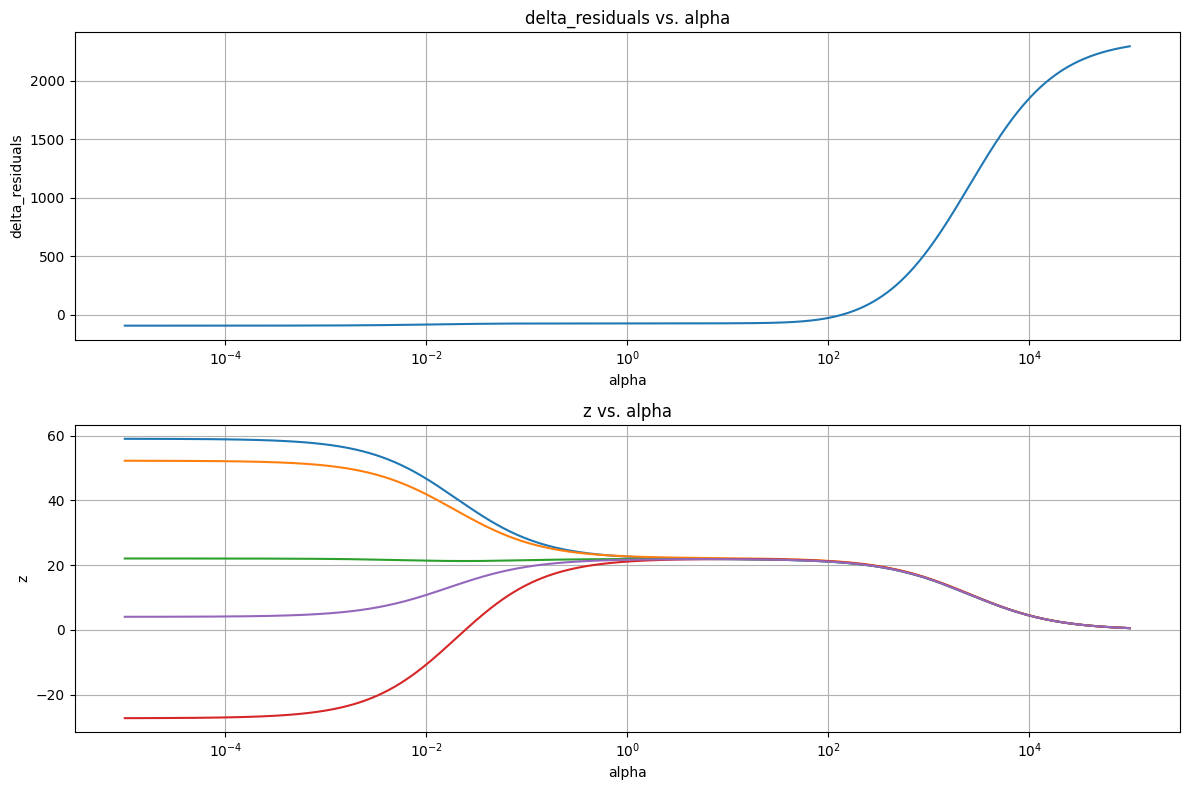

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(alpha_values, delta_residuals)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('delta_residuals')
plt.title('delta_residuals vs. alpha')
plt.grid(True)
print()

plt.subplot(2, 1, 2)
plt.plot(alpha_values, zs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('z')
plt.title('z vs. alpha')
plt.grid(True)

plt.tight_layout()
plt.show()